### Notebook for the label transfer of Healthy Human Reference to mouse ACM heart (merged Pkp2+Ttn dataset) using `scANVI`

#### Environment: scANVI

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 230918
- **Date of modification:** 240318

#### 1500 HVGs of **lymphoids** from Healthy human heart leucocytes (from Human cell atlas) are used as a reference for seed labelling

### Import required modules

In [71]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [72]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
absl                NA
array_api_compat    1.4.1
asttokens           NA
attr                23.2.0
chex                0.1.85
colorama            0.4.6
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
h5py                3.10.0
igraph              0.11.4
importlib_resources NA
ipykernel           6.29.3
ipywidgets          8.1.2
jax                 0.4.25
jaxlib              0.4.25
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mizani              0.11.0
ml_colle

In [73]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [74]:
torch.set_float32_matmul_precision('high')

In [75]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [76]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [77]:
# Data set with 1500 HVGs of myeloids from Healthy human heart leucocytes (from Human cell atlas) 

reference = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/HCA_lymphoids_healthy_reference_HVG1500_ac240308.raw.h5ad')
reference

AnnData object with n_obs × n_vars = 16403 × 1500
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'cell_states_colors', 'hvg', 'scNym_colors', 'scNym_probabilities'
    obsm: 'X_pca', 'X_scnym', 'X_umap'
    layers: 'counts'

In [78]:
X_is_raw(reference)

True

In [79]:
reference.obs['seed_labels'] = reference.obs['general_cell_types'].copy()
reference.obs['seed_labels'].cat.categories

Index(['B', 'CD4', 'CD8', 'NK', 'NKT'], dtype='object')

In [80]:
reference.obs['seed_labels'].value_counts() 

seed_labels
CD8    5957
CD4    4160
NK     3628
NKT    1463
B      1195
Name: count, dtype: int64

### Subset populations of interest

In [81]:
reference = reference[~reference.obs['seed_labels'].isin(['nan'])]              # = filter out not assigned cells, keep everything that is not 'nan'
reference.obs['seed_labels'].value_counts()

seed_labels
CD8    5957
CD4    4160
NK     3628
NKT    1463
B      1195
Name: count, dtype: int64

In [82]:
sc.pp.filter_cells(reference, min_genes = 50)                       #took 50 instead of 200 because otherwise too may cells would be lost 
sc.pp.filter_cells(reference, min_counts = 100)

filtered out 2757 cells that have less than 50 genes expressed
filtered out 91 cells that have less than 100 counts


### Read in query

In [83]:
#Merged Pkp2+Ttn Libraries subsetted to contain only control mice (Pkp_Ctr_noninf and Ttn_Ctr_noninf)

query = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/Merge+Subset_Ctrls_demux_QCed_ac240221.raw.h5ad')
query.obs['cell_source'] = 'AG_Gerull'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'cell_source', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    layers: 'counts', 'sqrt

In [84]:
X_is_raw(query)

True

In [85]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [86]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]                      #capitalize gene names to match with the human genes from reference
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

### Merge reference and query (make sure the seed_labels of query are 'Unknown')

In [87]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')                #merge to one adata object
adata

AnnData object with n_obs × n_vars = 21402 × 1109
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mean_counts-A4-query', 'pct_dropout_by_counts-A4-quer

In [88]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].cat.categories

Index(['B', 'CD4', 'CD8', 'NK', 'NKT', 'Unknown'], dtype='object')

In [89]:
adata.obs['batch'].value_counts()

batch
reference    13555
query         7847
Name: count, dtype: int64

### Select HVGs

In [90]:
adata.obs['donor'] = adata.obs['donor'].astype('str') 
adata.obs['donor'].value_counts()

donor
D7                   3509
D6                   3351
D11                  1958
Ttn_Ctr_noninf_1     1821
Pkp2_Ctr_noninf_2    1649
Ttn_Ctr_noninf_2     1548
Pkp2_Ctr_noninf_4    1236
H2                   1235
Pkp2_Ctr_noninf_3     909
Pkp2_Ctr_noninf_1     684
H3                    674
H6                    547
H5                    546
H4                    511
H7                    466
D3                    298
D2                    219
D5                    153
D4                     74
D1                     14
Name: count, dtype: int64

In [91]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 1109,
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 21402 × 1109
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mean_counts-A4-query', 'pct_dropout_by_counts-A4-quer

### Transfer of annotation with scANVI

In [92]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

In [93]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [94]:
scvi_model.train(44, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True,
                 accelerator = "gpu",
                 devices = [1]                                        
                 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 44/44: 100%|██████████| 44/44 [00:39<00:00,  1.10it/s, v_num=1, train_loss_step=414, train_loss_epoch=421]

`Trainer.fit` stopped: `max_epochs=44` reached.


Epoch 44/44: 100%|██████████| 44/44 [00:39<00:00,  1.11it/s, v_num=1, train_loss_step=414, train_loss_epoch=421]


### Evaluate model performance a la _Sevensson_

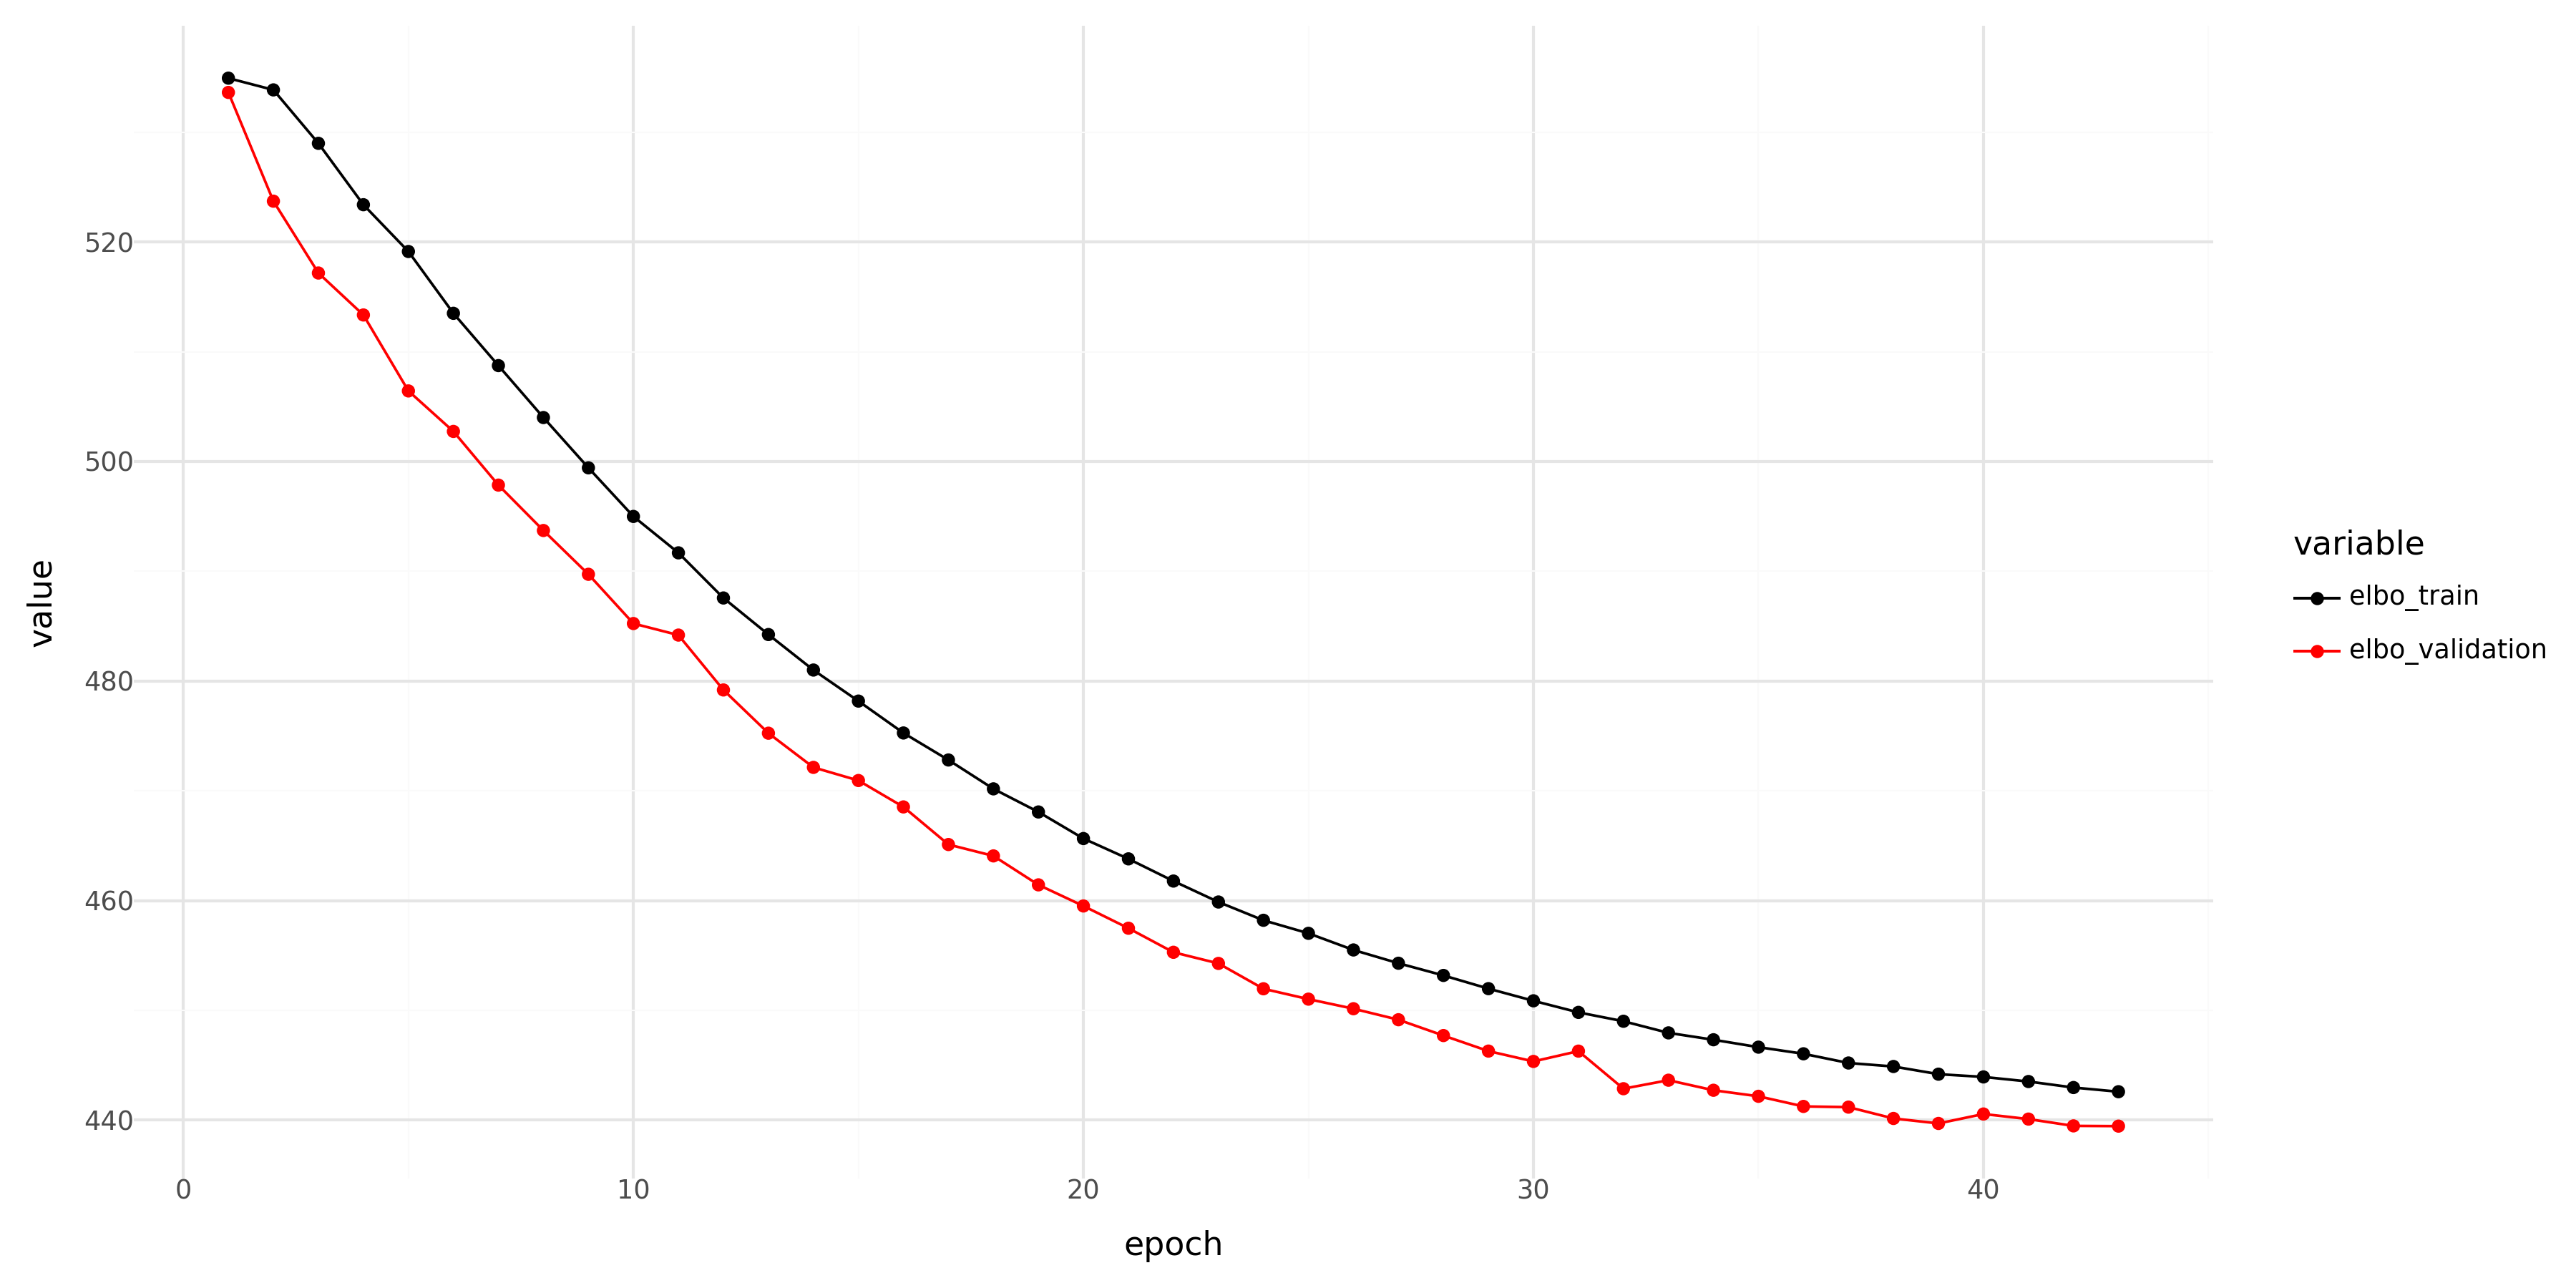

In [95]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

- get latent representation

In [96]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

### Label transfer with `scANVI` 

In [97]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [98]:
scanvi_model.train(7, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [1]                            
)

INFO     Training for 7 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 7/7: 100%|██████████| 7/7 [00:17<00:00,  2.40s/it, v_num=1, train_loss_step=432, train_loss_epoch=425]

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 7/7: 100%|██████████| 7/7 [00:17<00:00,  2.50s/it, v_num=1, train_loss_step=432, train_loss_epoch=425]


### Evaluate model performance a la Svensson

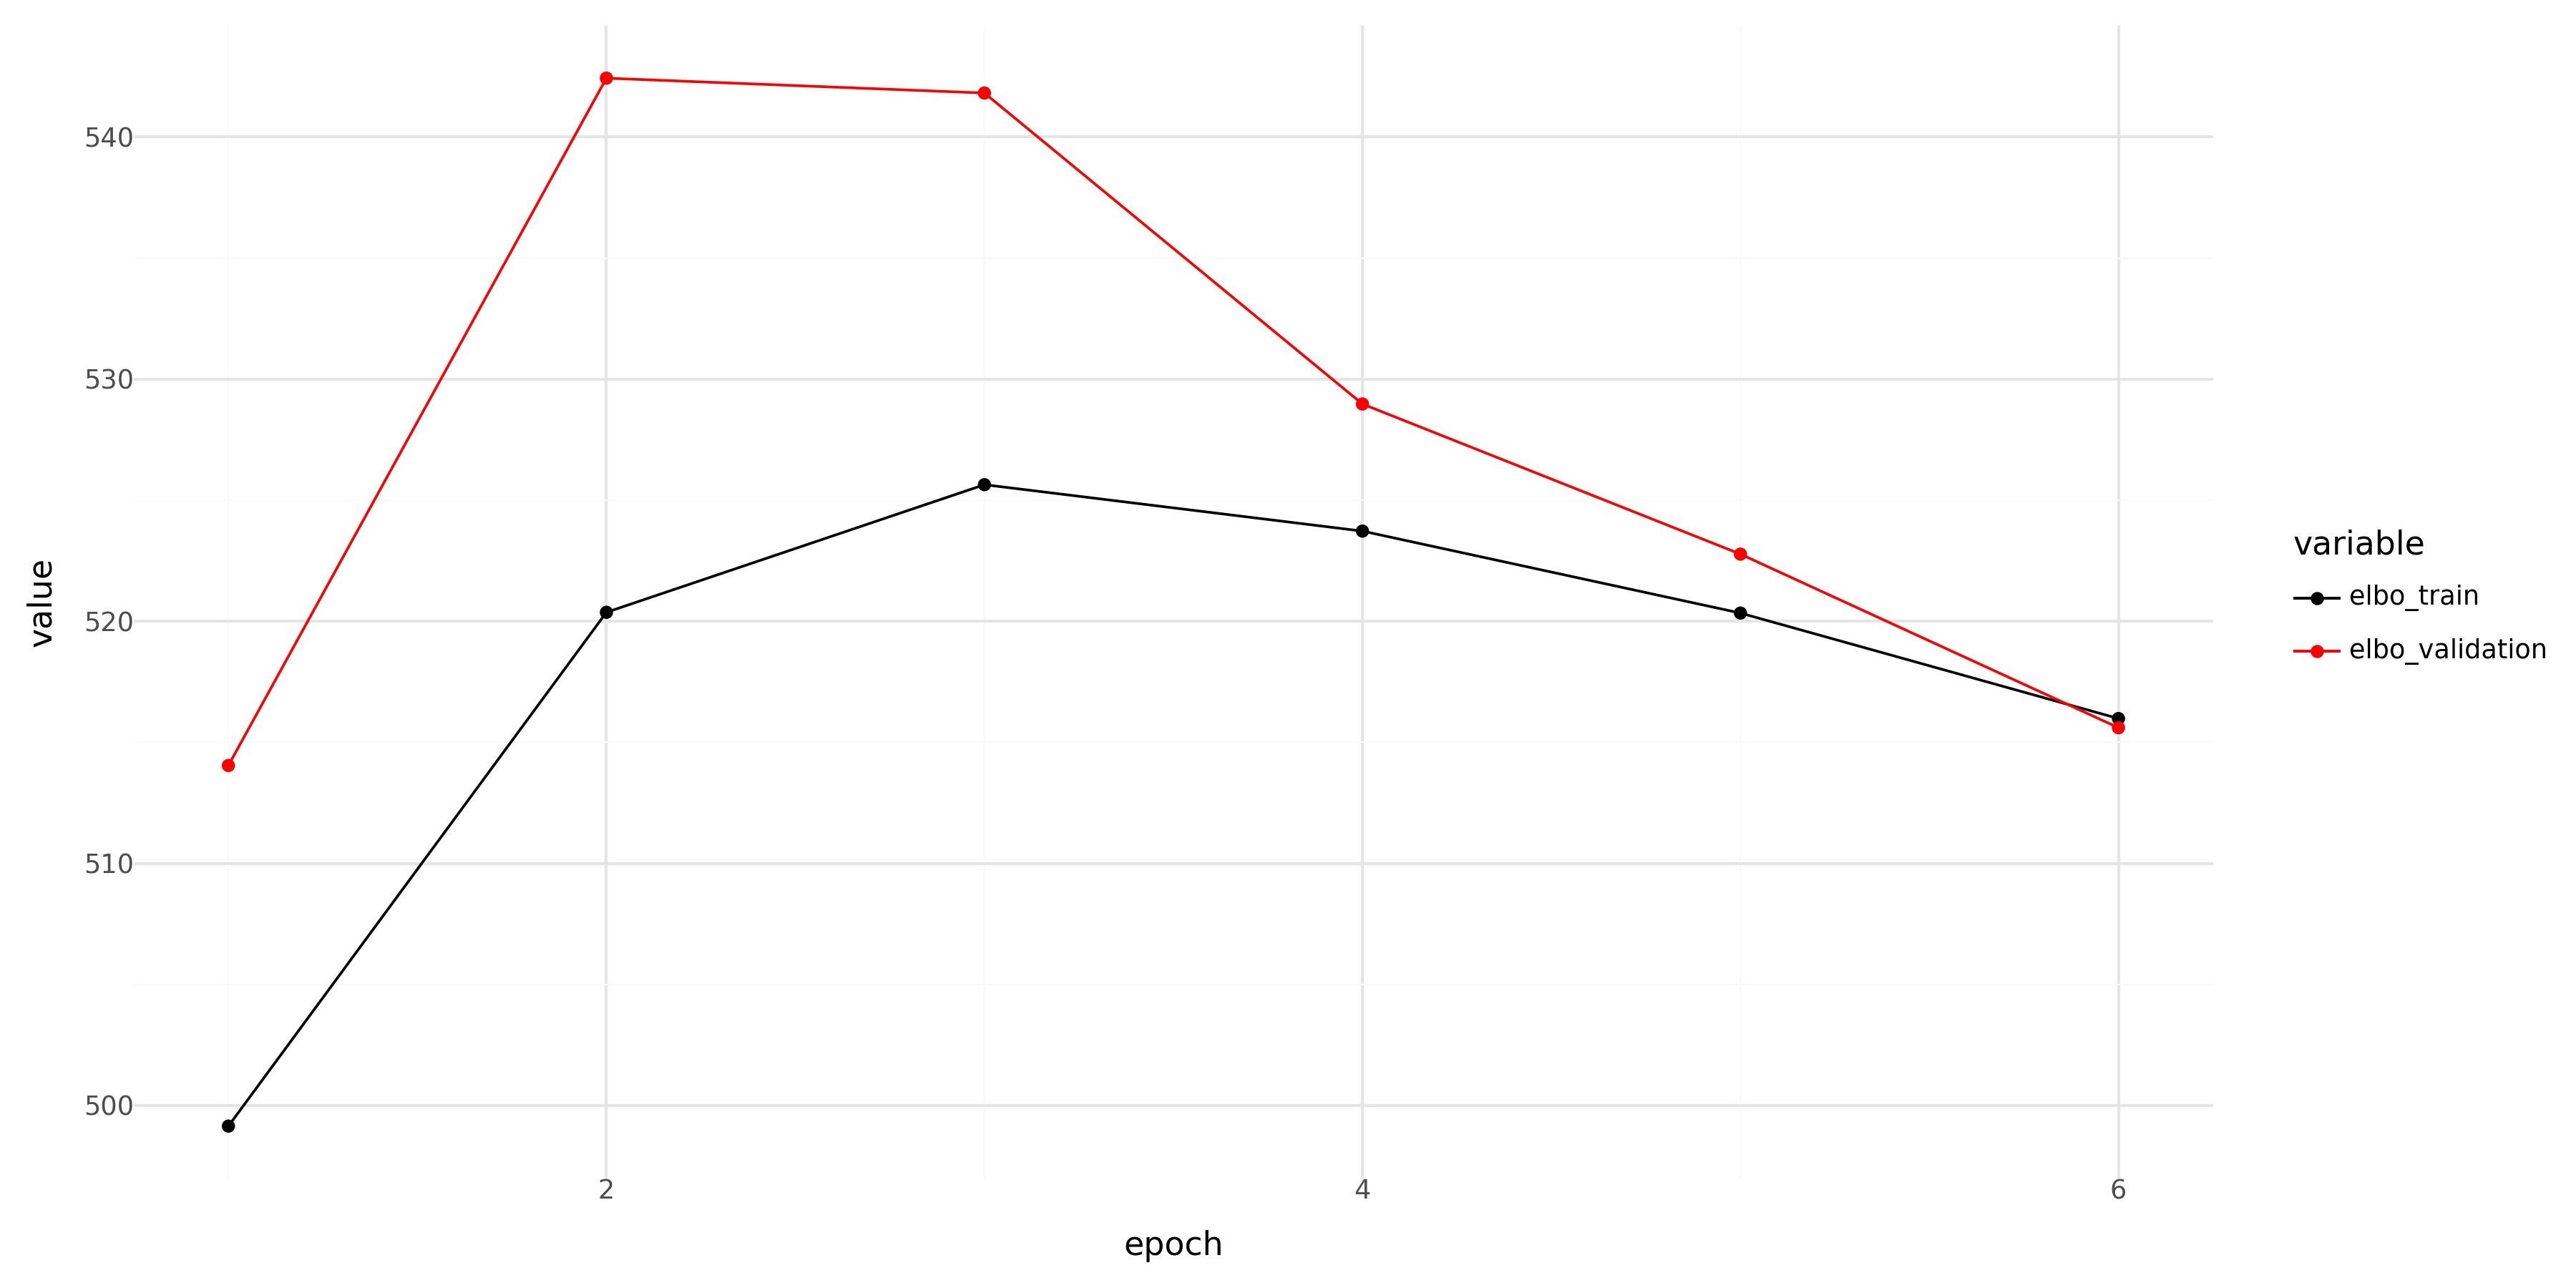

In [99]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig2.png', dpi = 300)

print(p_)

In [100]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [101]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [102]:
adata.obs

,NRP,cell_source,cell_states,donor,gender,n_counts,n_genes,region,sample,scNym,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAAGTGAAGTCGGCCT-1-H0015_apex-reference,No,Harvard-Nuclei,CD4+T_cytox,H5,Female,109.0,54,AX,H0015_apex,CD4+T_cell,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,11,1,CD8
AAATGGAAGGTCCCTG-1-H0015_apex-reference,No,Harvard-Nuclei,CD4+T_cytox,H5,Female,142.0,59,AX,H0015_apex,CD4+T_cell,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,11,1,CD4
AATCACGTCCCGTAAA-1-H0015_apex-reference,No,Harvard-Nuclei,CD8+T_tem,H5,Female,140.0,54,AX,H0015_apex,CD4+T_cell,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,11,2,CD8
AATGACCGTGTTGCCG-1-H0015_apex-reference,No,Harvard-Nuclei,NK,H5,Female,140.0,59,AX,H0015_apex,NK,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,11,3,NK
ACTTATCGTGTTCGAT-1-H0015_apex-reference,No,Harvard-Nuclei,CD8+T_cytox,H5,Female,197.0,82,AX,H0015_apex,CD4+T_cell,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,11,2,CD8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,NaN,AG_Gerull,NaN,Ttn_Ctr_noninf_2,NaN,18844.0,4219,NaN,Ttn_Ctr_noninf_2,NaN,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291862,query,19,5,CD8
TTTGGTTTCCTGTACC-1-B2-query,NaN,AG_Gerull,NaN,Ttn_Ctr_noninf_2,NaN,11805.0,3321,NaN,Ttn_Ctr_noninf_2,NaN,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query,19,5,CD8
TTTGTTGCAAGCTCTA-1-B2-query,NaN,AG_Gerull,NaN,Ttn_Ctr_noninf_1,NaN,3733.0,1849,NaN,Ttn_Ctr_noninf_1,NaN,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,18,5,CD8
TTTGTTGTCCCAGGAC-1-B2-query,NaN,AG_Gerull,NaN,Ttn_Ctr_noninf_2,NaN,6388.0,2559,NaN,Ttn_Ctr_noninf_2,NaN,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,19,5,CD8


- Visualise corrected dataset

In [103]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


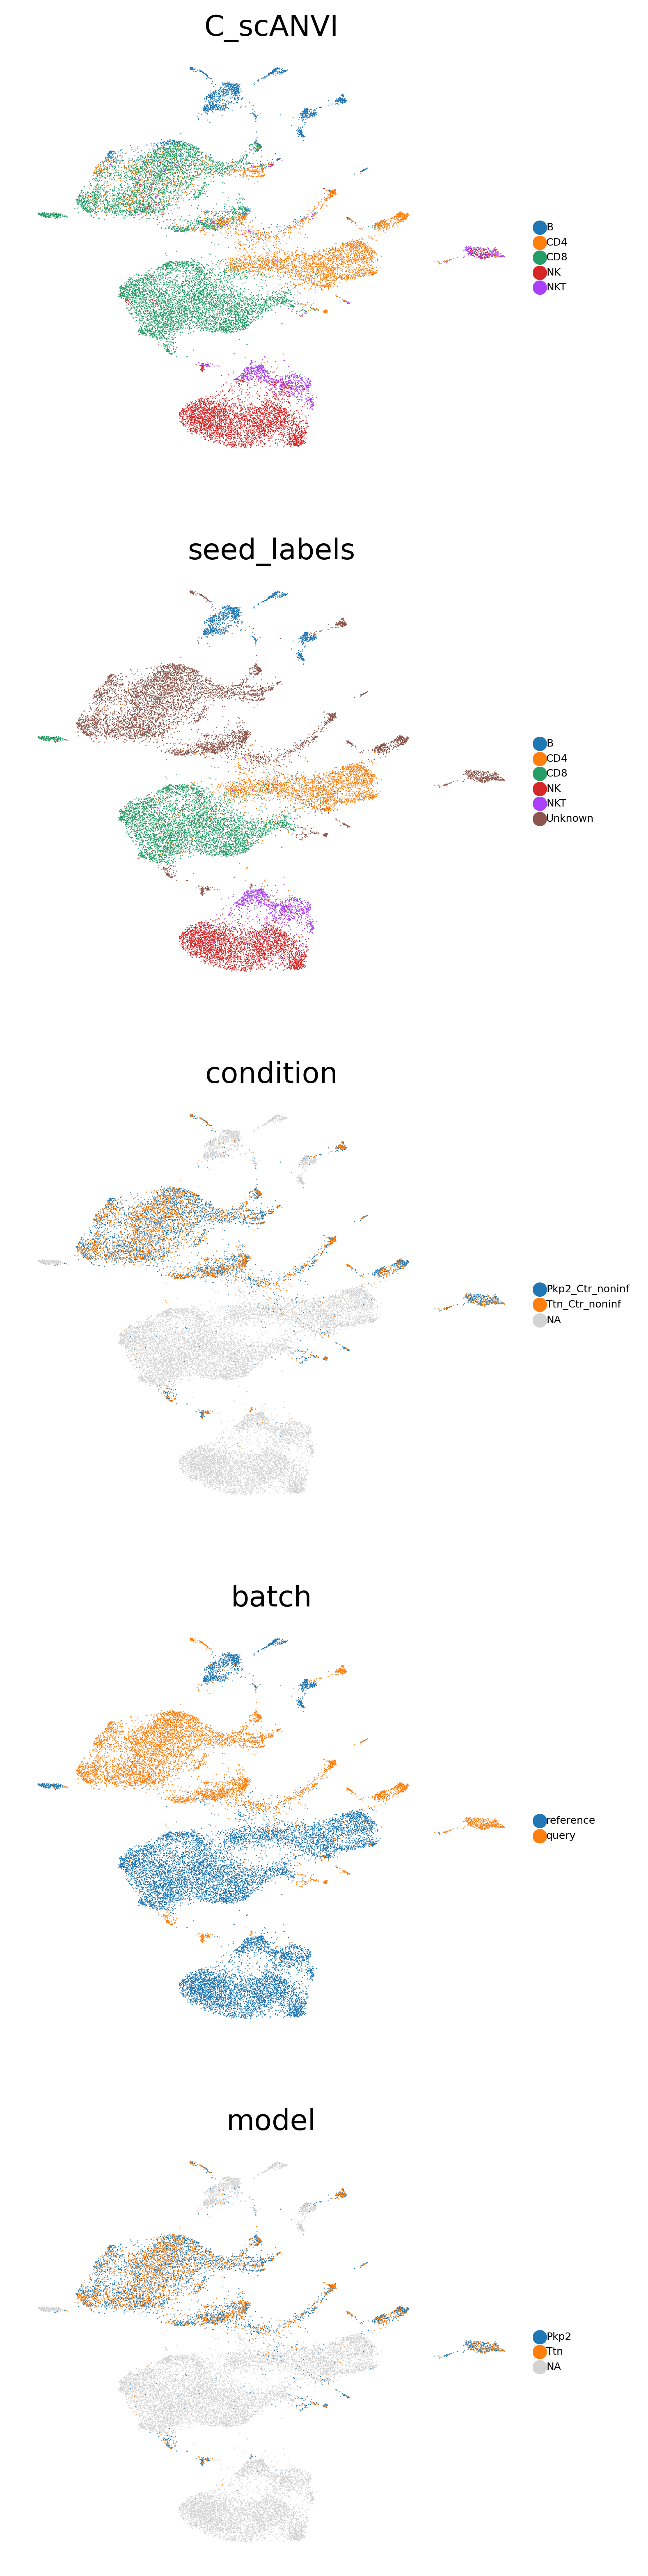

In [104]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'condition', 'batch', 'model'], size = 1, legend_fontsize = 5, ncols = 1)

### Compute `scib-metrics`

In [105]:
adata

AnnData object with n_obs × n_vars = 21402 × 1109
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mean_count

In [106]:
bm = Benchmarker(
    adata,
    batch_key="donor",
    label_key="seed_labels",                                       
    embedding_obsm_keys=["X_scVI", "X_scANVI", "X_pca"],
    n_jobs=-1,
)
bm.benchmark()

computing PCA
    with n_comps=50
    finished (0:00:00)


Embeddings: 100%|██████████| 3/3 [02:22<00:00, 47.51s/it]


In [107]:
print(adata.X.dtype)

float64


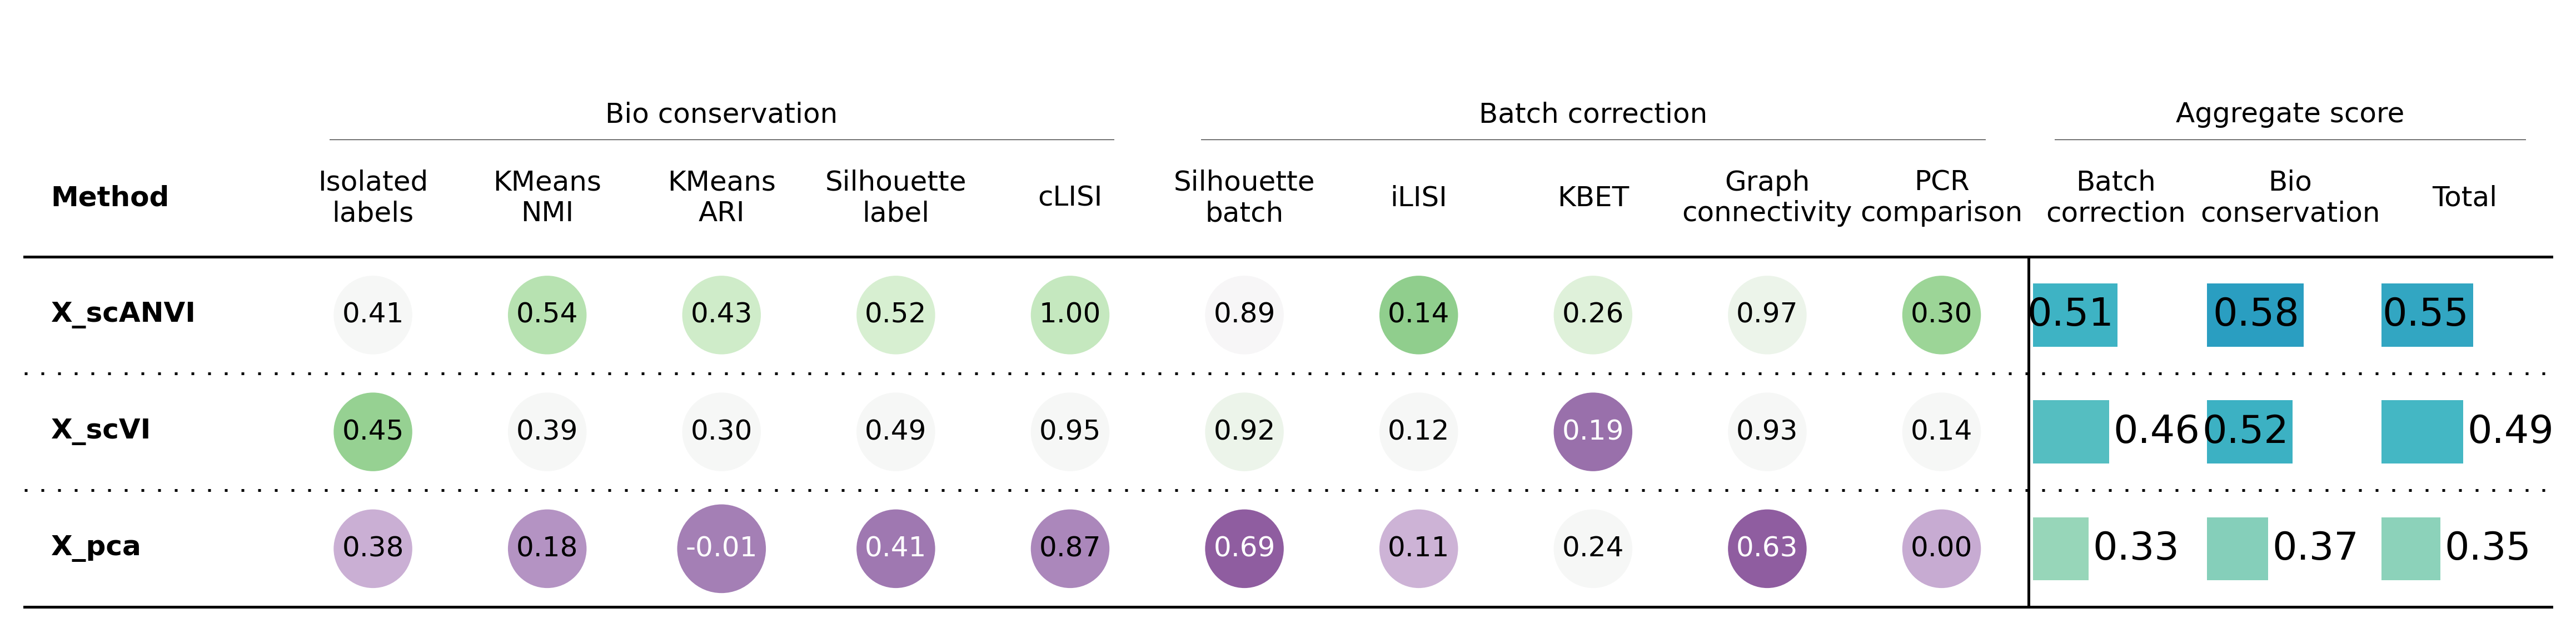

In [108]:
bm.plot_results_table(min_max_scale=False)

In [109]:
df = bm.get_results(min_max_scale=False)
df.transpose()

Embedding,X_scVI,X_scANVI,X_pca,Metric Type
Isolated labels,0.447554,0.409078,0.377884,Bio conservation
KMeans NMI,0.387114,0.535141,0.183311,Bio conservation
KMeans ARI,0.298191,0.433591,-0.007856,Bio conservation
Silhouette label,0.4929,0.524682,0.405326,Bio conservation
cLISI,0.952692,0.996422,0.871696,Bio conservation
Silhouette batch,0.91782,0.894498,0.691698,Batch correction
iLISI,0.120086,0.135409,0.108548,Batch correction
KBET,0.18666,0.256275,0.241856,Batch correction
Graph connectivity,0.932619,0.965329,0.627931,Batch correction
PCR comparison,0.141306,0.301335,0.0,Batch correction


### Export annotated object

In [110]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)            #export a merged AnnData object with raw values from X and raw genes but modified observations
adata_export_merged

AnnData object with n_obs × n_vars = 21402 × 1109
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mean_count

In [111]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]                    #subset merged data set to keep only query
adata_export

View of AnnData object with n_obs × n_vars = 7847 × 1109
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mea

### Add new gene symbols

In [112]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)                    #make sure to store the raw X values and the raw genes together with modified observations
query_export

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_d

### Revert gene symbols

In [113]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]           #restore mouse nomenclature
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'Ac163611.1', 'Ac163611.2', 'Ac140365.1', 'Ac124606.2',
       'Ac124606.1', 'Ac133095.2', 'Ac133095.1', 'Ac234645.1', 'Ac149090.1'],
      dtype='object', length=32285)

In [114]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
CD8    4222
CD4    2074
B       720
NKT     526
NK      305
Name: count, dtype: int64

In [115]:
query_export

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_d

In [116]:
#Clean up metadata - delete all columns that came from merging with reference data set

del(query_export.obs['cell_states'])
del(query_export.obs['gender'])
del(query_export.obs['NRP'])
del(query_export.obs['region'])
del(query_export.obs['scNym'])
del(query_export.obs['scNym_confidence'])
del(query_export.obs['lineage'])
del(query_export.obs['general_cell_types'])


In [117]:
query_export.obs

,cell_source,donor,n_counts,n_genes,sample,seed_labels,condition,genotype,infection,library,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAACCCAAGATACAGT-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_2,8562.0,2769,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,23.662696,0.019038,0.000000,0.0,-0.339369,-0.496060,query,15,5,CD4
AAACGCTGTTGTGTTG-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_1,750.0,365,Pkp2_Ctr_noninf_1,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,query,14,5,B
AAACGCTTCTCGCTCA-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_1,3855.0,1599,Pkp2_Ctr_noninf_1,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,1.815824,0.043320,0.025940,0.0,-0.169221,-0.390143,query,14,5,CD8
AAAGGTACAGAACATA-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_2,17536.0,3854,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,10.213276,0.027315,0.051323,0.0,-0.317632,-0.578954,query,15,5,NKT
AAAGTCCAGGGACACT-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_2,14174.0,3788,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,14.456046,0.023282,0.014110,0.0,-0.370103,-0.370084,query,15,5,CD8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_2,18844.0,4219,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291862,query,19,5,CD8
TTTGGTTTCCTGTACC-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_2,11805.0,3321,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query,19,5,CD8
TTTGTTGCAAGCTCTA-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_1,3733.0,1849,Ttn_Ctr_noninf_1,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,18,5,CD8
TTTGTTGTCCCAGGAC-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_2,6388.0,2559,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,19,5,CD8


In [118]:
query_export.write('/home/acirnu/data/ACM_cardiac_leuco/scANVI/Pkp2+Ttn_Ctrls_scANVI_cellstates_from_HCA_lymphoid1500_reference_ac240318.raw.h5ad')   

In [119]:
pd.crosstab(query_export.obs['C_scANVI'], query_export.obs['condition'])

condition,Pkp2_Ctr_noninf,Ttn_Ctr_noninf
C_scANVI,,
B,445,275
CD4,1228,846
CD8,2305,1917
NK,169,136
NKT,331,195
